https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset?resource=download

https://www.analyticsvidhya.com/blog/2021/07/customer-segmentation-using-rfm-analysis/

### Understanding about the data provided from Kagle Website

https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset?resource=download

- **Objective** : A company that sells some of the product, and you want to know how well does the selling performance of the product.

### Importing Required Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [2]:
df = pd.read_excel(r'C:\Users\samru\Study\Study_Abroad\Projects_To_Showcase\Customer_Segmentation\data\Online_Retail.xlsx')

### Exploratory Data Analysis

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df['InvoiceNo'].isna().any().any(), df['CustomerID'].isna().any().any(), df['CustomerID'].isna().sum()

(np.False_, np.True_, np.int64(135080))

In [6]:
duplicate_CustomerID = df[df['CustomerID'].duplicated()]['CustomerID']
print(f"Number of Duplicate CustomerIDsIDs {duplicate_CustomerID.shape}")

non_duplicated_CustomerID = df['CustomerID'].unique()
print(f"Number of Unique CustomerIDs {non_duplicated_CustomerID.shape}")

Number of Duplicate CustomerIDsIDs (537536,)
Number of Unique CustomerIDs (4373,)


- There are 135080 null customer IDs
- Only 4373 Customer IDs are unique and rest of them are duplicate or null

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- The 'Description' column has 1,454 null values, representing approximately 0.27% of the total dataset
- There are 135080 null values for CustomerID, representing almost around 25% of the total dataset
- The presence of null values in the 'Customer ID' field, which is a critical identifier, is unexpected

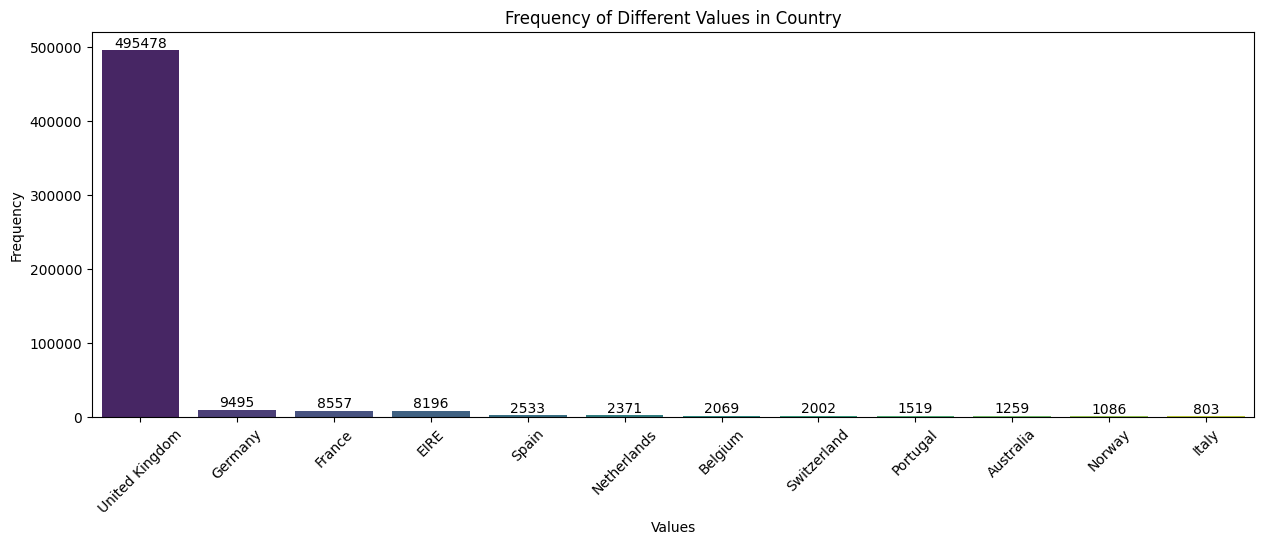

In [146]:
value_counts = df['Country'].value_counts()[:12]

# Bar plot using Seaborn
plt.figure(figsize=(15, 5))
ax = sns.barplot(x = value_counts.index, y = value_counts.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

It seems that the maximum audience is from United Kingdom

### Data Description

In [8]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


#### Exploring Quantity based on the irregularities found in the data description

In [9]:
df['Quantity'].max(), df['Quantity'].min(), df['Quantity'].mean()

(np.int64(80995), np.int64(-80995), np.float64(9.55224954743324))

- The minimum value of Quantity is -80,995
- The maimum value of Quantity is 80,995
- The mean value of 'Quantity' is approximately 10 and the standard deviation is also high, which suggests a potential imbalance in the dataset and the likelihood of outliers significantly influencing the distribution.

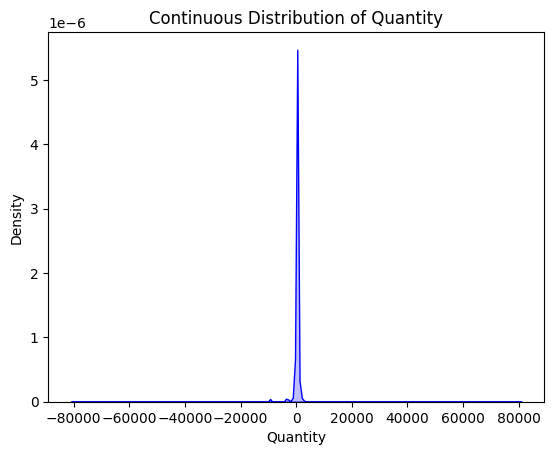

In [10]:
sns.kdeplot(df['Quantity'], shade=True, color='blue')
plt.title('Continuous Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

- This distribution shows that the plot is neither strongly right-skewed nor left skewed; instead it appears symmetrical around the central peak at zero.
- The presence of long tails extending to both the left (negative) and right (positive) suggests the data has extreme outliers in both directions rather than a clear directional skew.

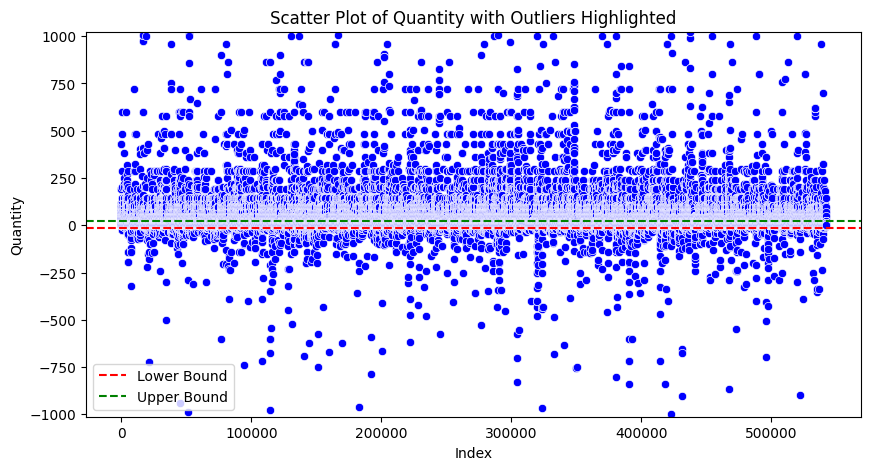

In [11]:
# Calculate IQR
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers_lower = df[df['Quantity'] < lower_bound]
outliers_upper = df[df['Quantity'] > upper_bound]


plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x=df.index, y='Quantity', color='blue')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axhline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.ylim(lower_bound - 1000, upper_bound + 1000)  # Adjust limits for better visibility
plt.title('Scatter Plot of Quantity with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.legend()
plt.show()

- I have adjusted the range of the Quantity values to extend a bit beyond ±1000 to provide a more focused view of the outliers. This zoomed-in perspective allows for a clearer identification and visualization of the extreme values that deviate from the expected range, making it easier to analyze the distribution of the data.

### Counting and Extracting Outliers

In [12]:
# Calculate IQR
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Quantity'] < lower_bound) | (df['Quantity'] > upper_bound)]

# Count of outliers
outlier_count = outliers.shape[0]
print(f"Number of outliers: {outlier_count}")

Number of outliers: 58619


- There are 58619 outliers in Quantity, which is around almost 11 % of the data
- There are negative and positive values in the Quantity

In [13]:
negative_count = (outliers['Quantity'] < 0).sum()

# Count the number of positive values
positive_count = (outliers['Quantity'] > 0).sum()

print(f"Number of negative values: {negative_count}")
print(f"Number of positive values: {positive_count}")

Number of negative values: 1984
Number of positive values: 56635


#### Exploring the patterns of data points having negative Quantity

In [14]:
negative_quan = outliers[outliers['Quantity'] < 0]

In [15]:
negative_quan.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom


In [16]:
negative_quan.shape

(1984, 8)

In [17]:
negative_quan.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,1984.000000,1984,1984.000000,1042.000000
mean,-230.394153,2011-07-07 11:03:47.872983808,0.958145,15045.279271
min,-80995.000000,2010-12-01 10:24:00,0.000000,12346.000000
25%,-100.000000,2011-04-03 16:58:45,0.000000,13694.000000
50%,-40.000000,2011-07-28 11:22:00,0.420000,14911.000000
75%,-24.000000,2011-10-13 12:15:15,1.250000,16303.000000
max,-13.000000,2011-12-09 09:27:00,12.750000,18274.000000
std,2519.627498,NaN,1.598843,1650.429877


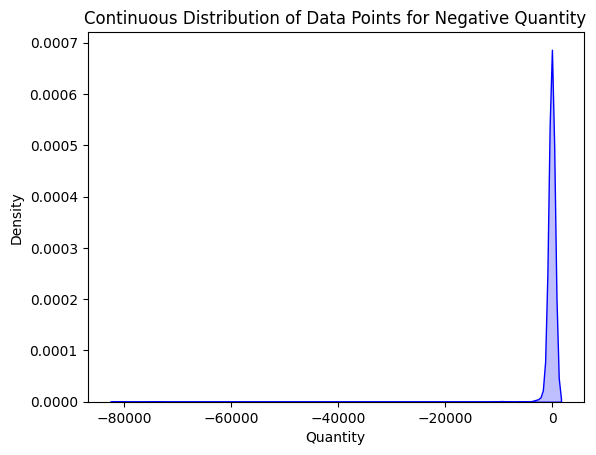

In [18]:
sns.kdeplot(negative_quan['Quantity'], shade=True, color='blue')
plt.title('Continuous Distribution of Data Points for Negative Quantity')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

- This looks like a left skewed data distribution

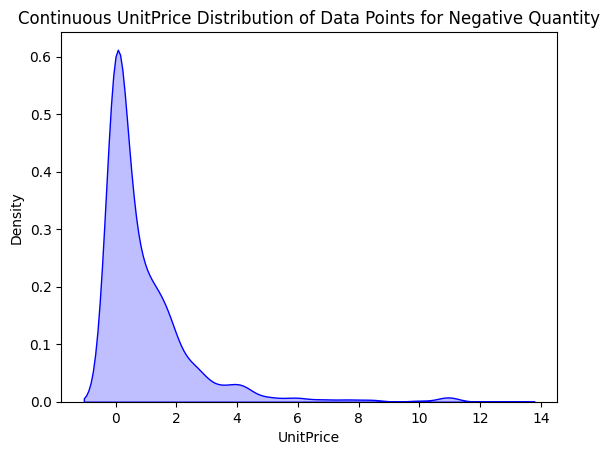

In [19]:
sns.kdeplot(negative_quan['UnitPrice'], shade=True, color='blue')
plt.title('Continuous UnitPrice Distribution of Data Points for Negative Quantity')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

- This looks like a positive skewed data distribution
- The data distribution for UnitPrice seems to be exactly opposite to that of Quantity in terms of skewness

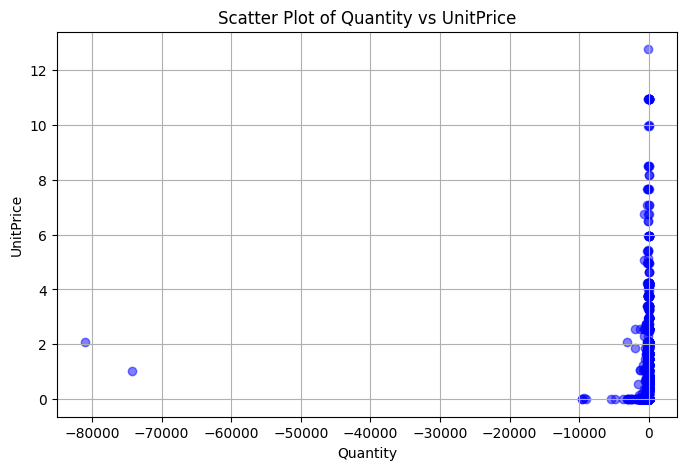

In [20]:
# Scatter plot using Matplotlib
plt.figure(figsize = (8, 5))
plt.scatter(negative_quan['Quantity'], negative_quan['UnitPrice'], color = 'blue', alpha = 0.5)
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.grid(True)
plt.show()

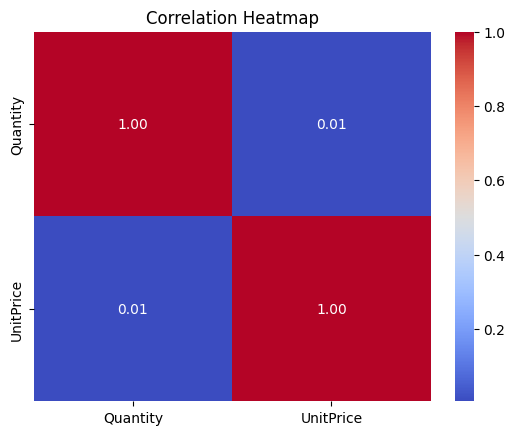

In [21]:
# Calculate correlation
correlation_matrix = negative_quan[['Quantity', 'UnitPrice']].corr()

# Heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

- Although the correlation heatmap shows that quantity and UnitPrice are not much correlated, the scatter plot shows that as the Quantity increases the UnitPrice increases for negative values of Quantity

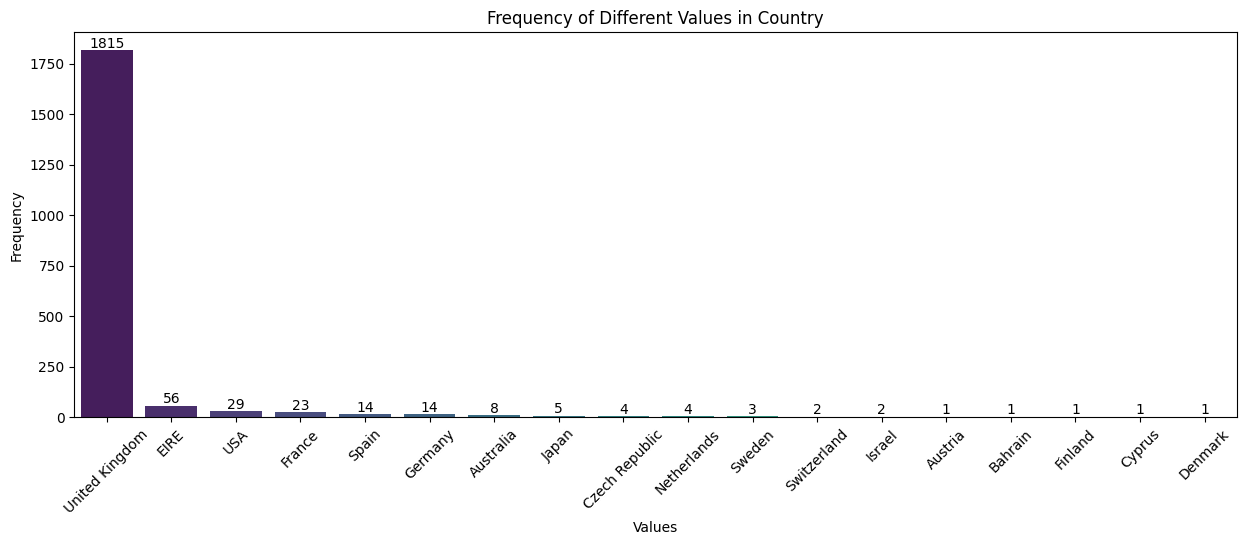

In [22]:
value_counts = negative_quan['Country'].value_counts()

# Bar plot using Seaborn
plt.figure(figsize=(15, 5))
ax = sns.barplot(x = value_counts.index, y = value_counts.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

- It looks like United Kingdom has the highest negative quantities

In [23]:
start_date = negative_quan['InvoiceDate'].min()  # Find the earliest date
end_date = negative_quan['InvoiceDate'].max()    # Find the latest date

# Calculate the range (difference between start and end date)
date_range = end_date - start_date

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Date Range: {date_range}")

Start Date: 2010-12-01 10:24:00
End Date: 2011-12-09 09:27:00
Date Range: 372 days 23:03:00


In [24]:
most_frequent_date_neg = negative_quan['InvoiceDate'].value_counts().idxmax()
frequency_neg = negative_quan['InvoiceDate'].value_counts().max()
print(f"Most Frequent Date: {most_frequent_date_neg} (Occurs {frequency_neg} times)")
filtered_rows_neg = negative_quan[negative_quan['InvoiceDate'] == most_frequent_date_neg]

Most Frequent Date: 2011-10-12 16:17:00 (Occurs 24 times)


In [25]:
filtered_rows_neg.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
394006,C570867,23078,ICE CREAM PEN LIP GLOSS,-24,2011-10-12 16:17:00,1.25,12607.0,USA
394007,C570867,23077,DOUGHNUT LIP GLOSS,-20,2011-10-12 16:17:00,1.25,12607.0,USA
394013,C570867,22959,WRAP CHRISTMAS VILLAGE,-25,2011-10-12 16:17:00,0.42,12607.0,USA
394014,C570867,22951,60 CAKE CASES DOLLY GIRL DESIGN,-24,2011-10-12 16:17:00,0.55,12607.0,USA
394027,C570867,22708,WRAP DOLLY GIRL,-25,2011-10-12 16:17:00,0.42,12607.0,USA


In [26]:
filtered_rows_neg.shape

(24, 8)

In [27]:
filtered_rows_neg['Country'].unique()

array(['USA'], dtype=object)

In [28]:
filtered_rows_neg['Description'].unique()

array(['ICE CREAM PEN LIP GLOSS ', 'DOUGHNUT LIP GLOSS ',
       'WRAP CHRISTMAS VILLAGE', '60 CAKE CASES DOLLY GIRL DESIGN',
       'WRAP DOLLY GIRL', 'WRAP COWBOYS  ', 'MINI PAINT SET VINTAGE ',
       'PACK OF 60 SPACEBOY CAKE CASES', 'PINK PAISLEY ROSE GIFT WRAP',
       'BIRTHDAY BANQUET GIFT WRAP', 'TEA PARTY  WRAPPING PAPER ',
       'PACK OF 60 MUSHROOM CAKE CASES', 'BLUE POLKADOT WRAP',
       'RED RETROSPOT WRAP ', 'PACK OF 72 RETROSPOT CAKE CASES',
       'SET/10 BLUE POLKADOT PARTY CANDLES',
       'SET/10 IVORY POLKADOT PARTY CANDLES',
       'SET/10 PINK POLKADOT PARTY CANDLES',
       'SET/10 RED POLKADOT PARTY CANDLES', 'WRAP ENGLISH ROSE ',
       '60 TEATIME FAIRY CAKE CASES', 'SET 36 COLOUR PENCILS DOLLY GIRL',
       'SET 12 COLOUR PENCILS SPACEBOY ',
       'SET OF 60 I LOVE LONDON CAKE CASES '], dtype=object)

In [29]:
filtered_rows_neg['InvoiceNo'].unique()

array(['C570867'], dtype=object)

In [30]:
filtered_rows_neg['CustomerID'].unique()

array([12607.])

- It seems that the customer with customer ID 14911 has purchased a lot of items on the same day

### Extracting Year, Month, Day, Day of Week, and Hour

In [31]:
negative_quan['Year'] = negative_quan['InvoiceDate'].dt.year
negative_quan['Month'] = negative_quan['InvoiceDate'].dt.month
negative_quan['Day'] = negative_quan['InvoiceDate'].dt.day
negative_quan['DayOfWeek'] = negative_quan['InvoiceDate'].dt.day_name()  # Get full day name (e.g., Monday, Tuesday)
negative_quan['Hour'] = negative_quan['InvoiceDate'].dt.hour

In [32]:
negative_quan.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,Wednesday,10
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,Wednesday,10
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,Wednesday,10
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,1,Wednesday,10
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,2010,12,2,Thursday,14


### Analyzing Day-of-Week Trends

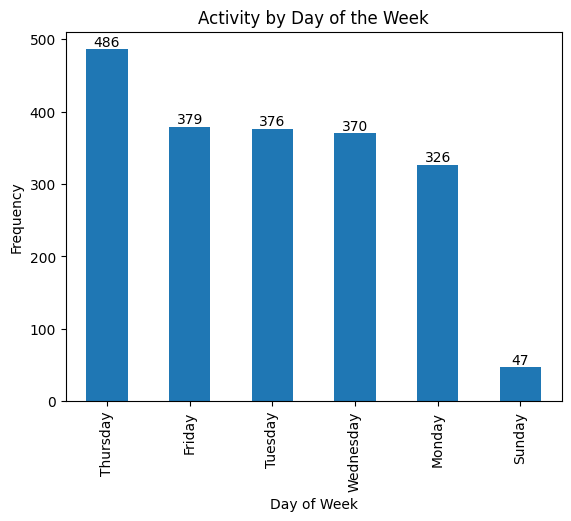

In [33]:

day_of_week_counts = negative_quan['DayOfWeek'].value_counts()

# Visualization
day_of_week_counts.plot(kind = 'bar', title = 'Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

for i, value in enumerate(day_of_week_counts):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


- The majority of the transactions have negative quantities occur on Thursday with 486 instances. This suggests that Thursday might be a peak day for customer interactions 
- Sunday has the transactions, with only 47 instances. This aligns with the assumption that Sunday might be a day of reduced business operations or fewer customer interactions.
- We can see that there is no transaction happening on Saturday, which highlights that the trend that there is not much activity during the weekends

### Analyzing Month-of-Year Trends

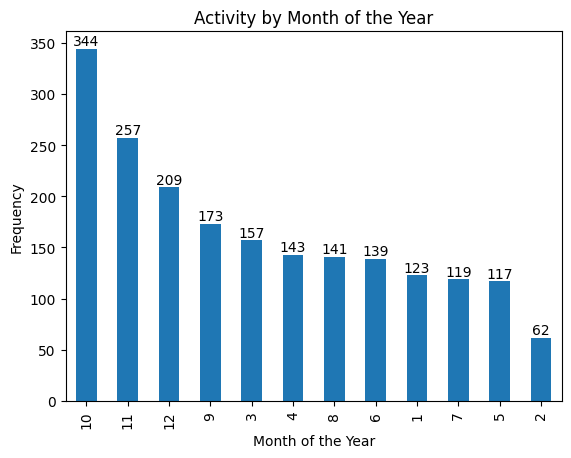

In [34]:
month_of_year_counts = negative_quan['Month'].value_counts()

# Visualization
month_of_year_counts.plot(kind = 'bar', title = 'Activity by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Frequency')

for i, value in enumerate(month_of_year_counts):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


- October has the highest number of recorded transactions (344), indicating it was the most active month for the dataset in terms of total activity.
- February has the lowest number of recorded transactions (62), showing minimal activity during this month.
- After December, there is a steady decline in the number of transactions, which highlights the trend that most of the activity happens around end of the year

### Analyzing Day-of-Month Trends

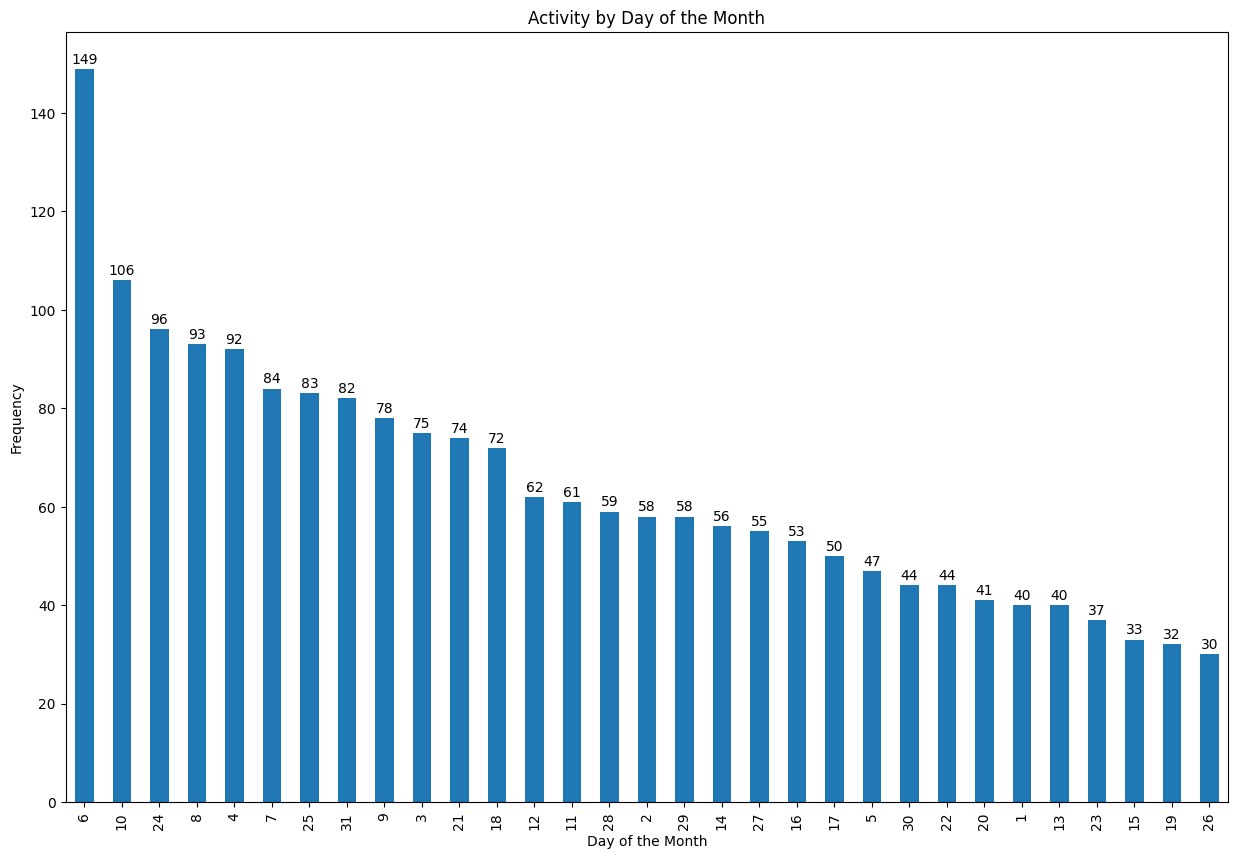

In [35]:
plt.figure(figsize=(15, 10))
Day_of_month_counts = negative_quan['Day'].value_counts()

# Visualization
Day_of_month_counts.plot(kind = 'bar', title = 'Activity by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

for i, value in enumerate(Day_of_month_counts):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


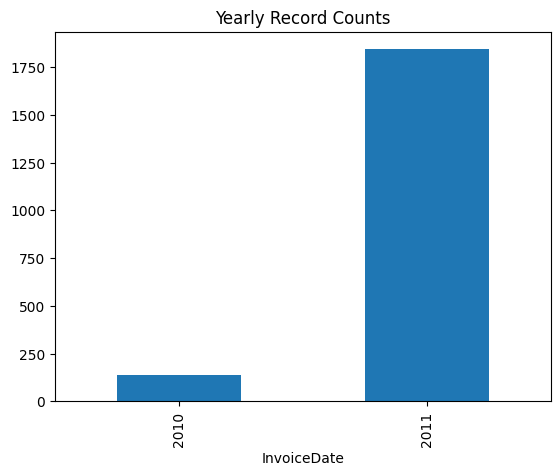

In [36]:
yearly_counts = negative_quan.groupby(negative_quan['InvoiceDate'].dt.year).size()
yearly_counts.plot(kind='bar', title='Yearly Record Counts')
plt.show()

- Most of the transactions seems to have happened in 2011

- Invoices with negative quantities are likely due to cancellations or returns. These transactions require a deeper understanding of the context or background to accurately interpret why the quantities are negative. 
- For the purpose of this clustering exploration, I will exclude these Invoices which are having negative quantities 

### Checking the above insights for the invoices having positive Quantities for the outliers

In [37]:
positive_quan = outliers[outliers['Quantity'] >= 0]

In [38]:
positive_quan.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France
31,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583.0,France


In [39]:
positive_quan.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,56635.000000,56635,56635.000000,54485.000000
mean,60.434254,2011-07-07 05:15:14.071157504,1.305553,15036.730513
min,24.000000,2010-12-01 08:34:00,0.000000,12346.000000
25%,24.000000,2011-04-05 13:56:00,0.420000,13563.000000
50%,25.000000,2011-07-26 12:03:00,0.850000,14883.000000
75%,48.000000,2011-10-12 12:42:00,1.650000,16558.000000
max,80995.000000,2011-12-09 12:49:00,649.500000,18287.000000
std,477.277553,NaN,3.087368,1728.463649


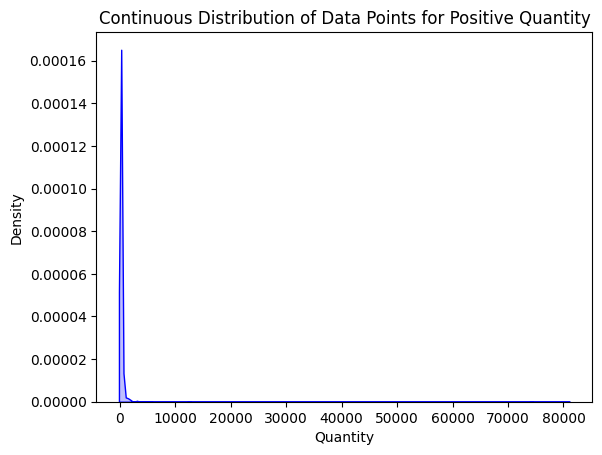

In [40]:
sns.kdeplot(positive_quan['Quantity'], shade=True, color='blue')
plt.title('Continuous Distribution of Data Points for Positive Quantity')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

- This looks like a right skewed data distribution

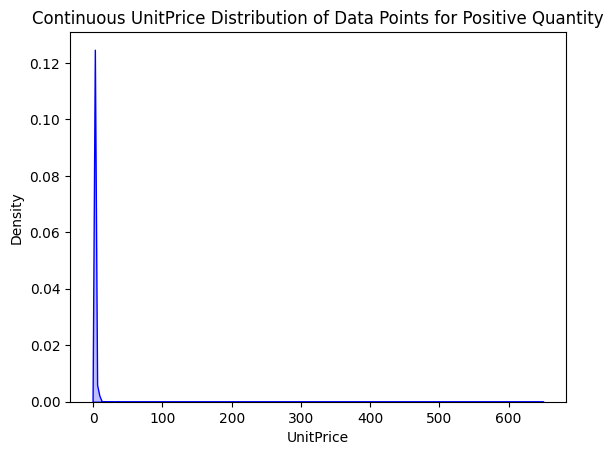

In [41]:
sns.kdeplot(positive_quan['UnitPrice'], shade=True, color='blue')
plt.title('Continuous UnitPrice Distribution of Data Points for Positive Quantity')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

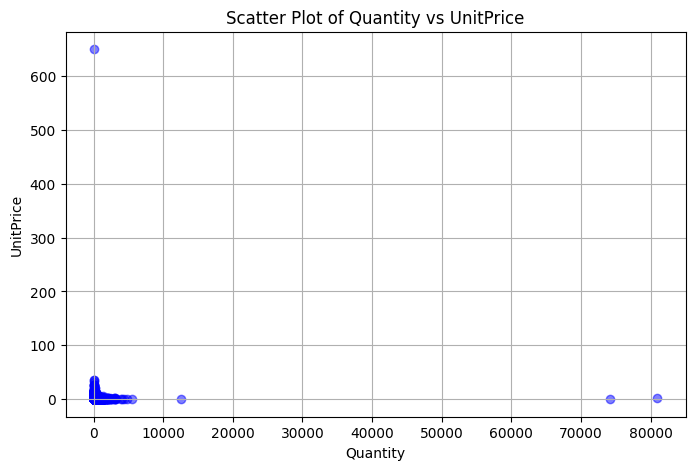

In [42]:
# Scatter plot using Matplotlib
plt.figure(figsize = (8, 5))
plt.scatter(positive_quan['Quantity'], positive_quan['UnitPrice'], color = 'blue', alpha = 0.5)
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.grid(True)
plt.show()

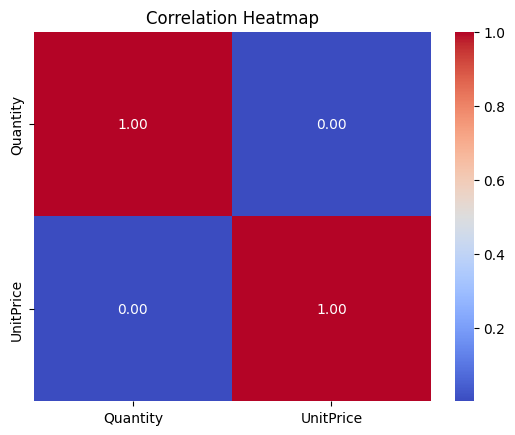

In [43]:
# Calculate correlation
correlation_matrix_pos = positive_quan[['Quantity', 'UnitPrice']].corr()

# Heatmap using Seaborn
sns.heatmap(correlation_matrix_pos, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Heatmap')
plt.show()

- There seems to be no correlation between Quantity and UnitPrice

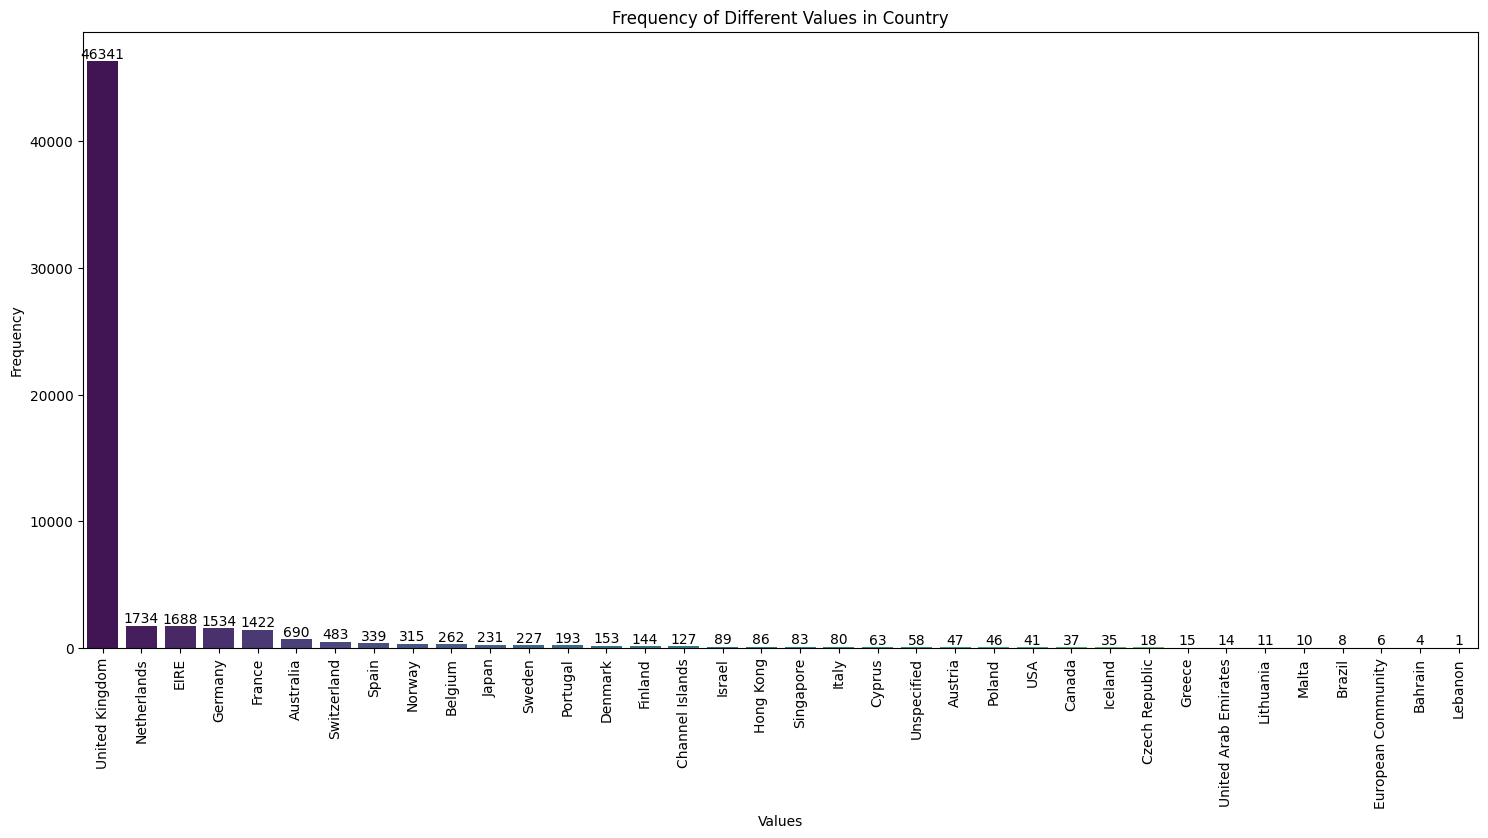

In [44]:
value_counts = positive_quan['Country'].value_counts()

# Bar plot using Seaborn
plt.figure(figsize = (18, 8))
ax = sns.barplot(x = value_counts.index, y = value_counts.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, 5), 
                textcoords = 'offset points')
plt.show()

- It looks like United Kingdom has the highest positive quantities
- These are the countries which has Invoices of only positive quantities
   * Norway
   * Poland
   * Italy
   * Belgium
   * Lithuania
   * Iceland
   * Portugal
   * Channel Islands
   * Greece
   * Hong Kong
   * Singapore
   * Lebanon
   * United Arab Emirates
   * Unspecified
   * Brazil
   * Canada
   * Malta
   * European Community

In [45]:
start_date_pos = positive_quan['InvoiceDate'].min()  # Find the earliest date
end_date_pos = positive_quan['InvoiceDate'].max()    # Find the latest date

# Calculate the range (difference between start and end date)
date_range_pos = end_date_pos - start_date_pos

print(f"Start Date: {start_date_pos}")
print(f"End Date: {end_date_pos}")
print(f"Date Range: {date_range_pos}")

Start Date: 2010-12-01 08:34:00
End Date: 2011-12-09 12:49:00
Date Range: 373 days 04:15:00


In [46]:
most_frequent_date_pos = positive_quan['InvoiceDate'].value_counts().idxmax()
frequency_pos = positive_quan['InvoiceDate'].value_counts().max()
print(f"Most Frequent Date: {most_frequent_date_pos} (Occurs {frequency_pos} times)")
filtered_rows_pos = positive_quan[positive_quan['InvoiceDate'] == most_frequent_date_pos]

Most Frequent Date: 2011-06-15 13:37:00 (Occurs 134 times)


In [47]:
filtered_rows_pos.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
228155,556917,21993,FLORAL FOLK STATIONERY SET,60,2011-06-15 13:37:00,1.25,12415.0,Australia
228156,556917,21933,PINK VINTAGE PAISLEY PICNIC BAG,100,2011-06-15 13:37:00,1.65,12415.0,Australia
228157,556917,21990,MODERN FLORAL STATIONERY SET,72,2011-06-15 13:37:00,1.25,12415.0,Australia
228158,556917,84944,SET OF 6 KASHMIR FOLKART BAUBLES,60,2011-06-15 13:37:00,1.65,12415.0,Australia
228159,556917,21929,JUMBO BAG PINK VINTAGE PAISLEY,100,2011-06-15 13:37:00,1.79,12415.0,Australia


In [48]:
filtered_rows_pos['InvoiceNo'].unique()

array([556917, 556918], dtype=object)

In [49]:
filtered_rows_pos['InvoiceDate'].unique()

<DatetimeArray>
['2011-06-15 13:37:00']
Length: 1, dtype: datetime64[ns]

In [50]:
filtered_rows_pos['CustomerID'].unique()

array([12415.])

In [51]:
filtered_rows_pos['Country'].unique()

array(['Australia'], dtype=object)

### Extracting Year, Month, Day, Day of Week, and Hour

In [52]:
positive_quan['Year'] = positive_quan['InvoiceDate'].dt.year
positive_quan['Month'] = positive_quan['InvoiceDate'].dt.month
positive_quan['Day'] = positive_quan['InvoiceDate'].dt.day
positive_quan['DayOfWeek'] = positive_quan['InvoiceDate'].dt.day_name()  # Get full day name (e.g., Monday, Tuesday)
positive_quan['Hour'] = positive_quan['InvoiceDate'].dt.hour

In [53]:
positive_quan.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,2010,12,1,Wednesday,8
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,2010,12,1,Wednesday,8
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,2010,12,1,Wednesday,8
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France,2010,12,1,Wednesday,8
31,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583.0,France,2010,12,1,Wednesday,8


### Analyzing Day-of-Week Trends

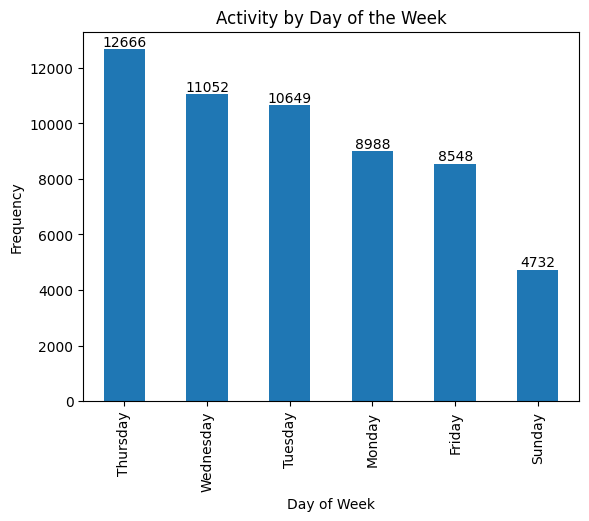

In [54]:
day_of_week_counts_pos = positive_quan['DayOfWeek'].value_counts()

# Visualization
day_of_week_counts_pos.plot(kind = 'bar', title = 'Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

for i, value in enumerate(day_of_week_counts_pos):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


- This same pattern was seen in invoices with positive quantities, that majority of the transactions occurred on Thursday and very less transactions occurred on Sunday
- Similar to the invoices with negative quantities, there is no activity happening on Saturday, and the trend here also shows less activity around the weekend

### Analyzing Month-of-Year Trends

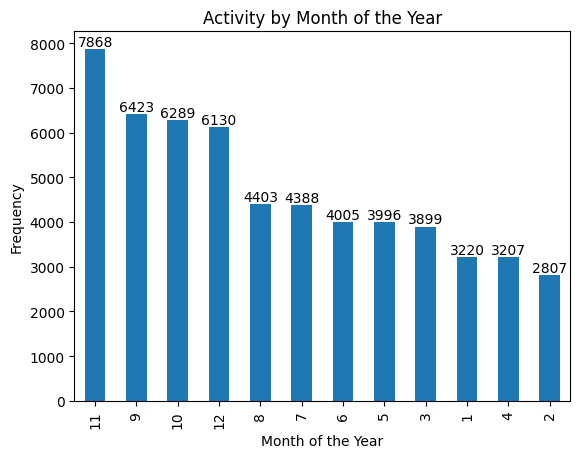

In [55]:
month_of_year_counts_pos = positive_quan['Month'].value_counts()

# Visualization
month_of_year_counts_pos.plot(kind = 'bar', title = 'Activity by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Frequency')

for i, value in enumerate(month_of_year_counts_pos):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


- November has the highest number of recorded transactions (7868), indicating it was the most active month for the dataset in terms of total activity.
- February has the lowest number of recorded transactions (2807), showing minimal activity during this month.
- After December, there is a steady decline in the number of transactions, which highlights the trend that most of the activity happens around end of the year

### Analyzing Day-of-Month Trends

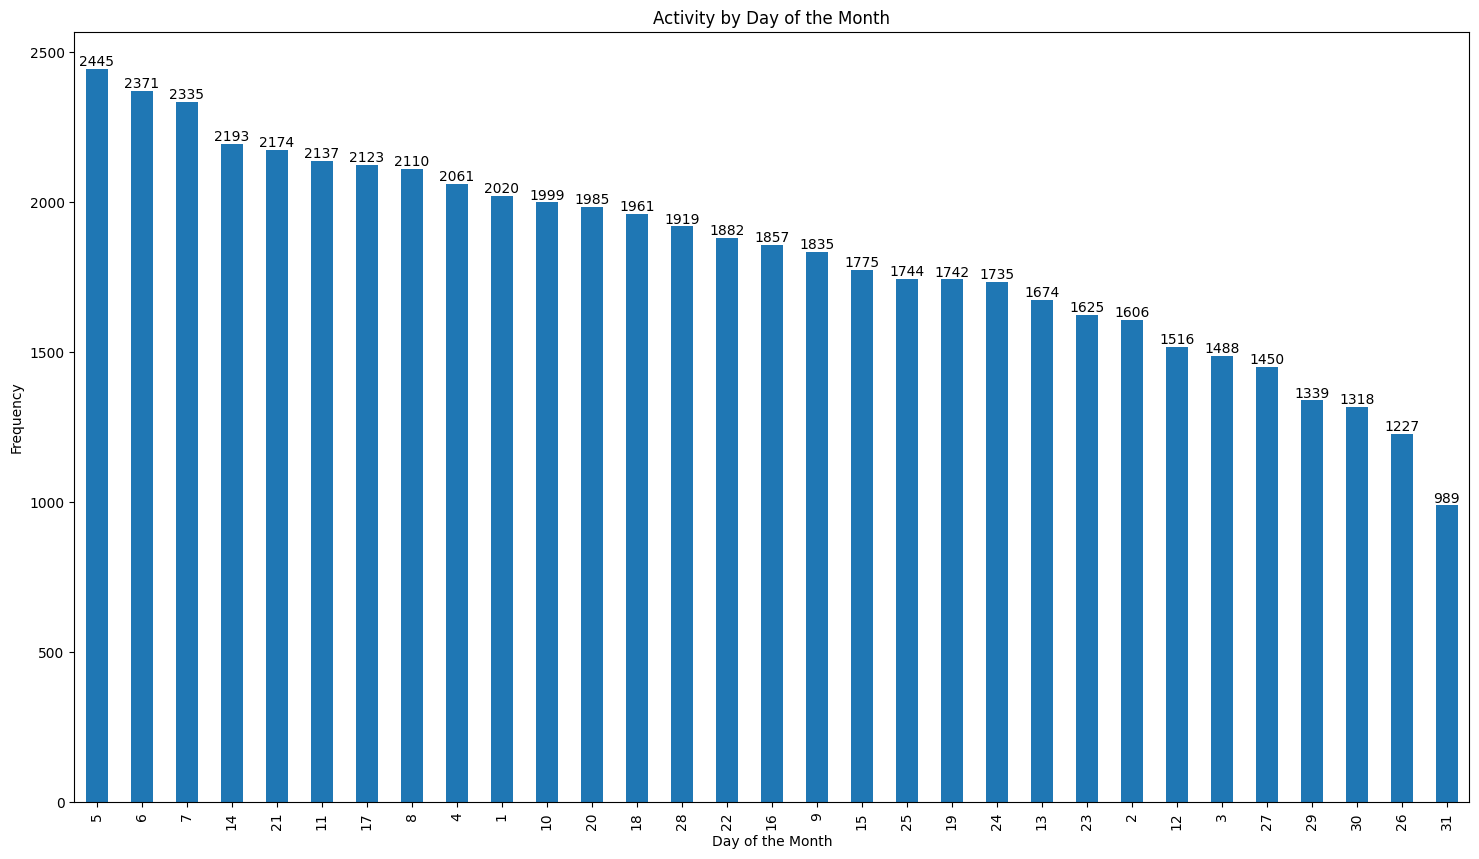

In [56]:
plt.figure(figsize=(18, 10))
Day_of_month_counts_pos = positive_quan['Day'].value_counts()

# Visualization
Day_of_month_counts_pos.plot(kind = 'bar', title = 'Activity by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

for i, value in enumerate(Day_of_month_counts_pos):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


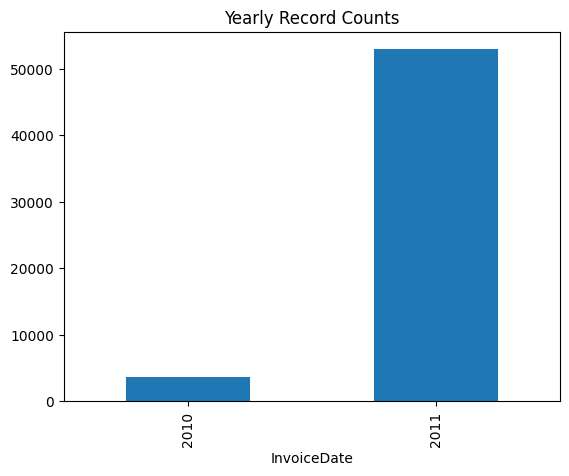

In [57]:
yearly_counts_pos = positive_quan.groupby(positive_quan['InvoiceDate'].dt.year).size()
yearly_counts_pos.plot(kind='bar', title='Yearly Record Counts')
plt.show()

- Like the Invoices for Negative Quantities, the invoices for positive quantities also show that maximum transactions have happened in the year 2011

**Conclusions from the above EDA for Quantity :**
- **Negative Quantities**: It is advisable to exclude data points with negative quantities since quantities cannot logically be negative. Additionally, this dataset lacks sufficient context to explain the meaning of negative values.
- **Positive Outliers**: For data points with positive quantities identified as outliers, further analysis is required. I will examine the distribution of normal positive quantities and compare them with these outliers to keep or replace these values
- Most of the activity happens in the weekdays rather than weekend in terms of days of the week
- Most of the activity happens in the last few months in terms of months of the year

### Exploring UnitPrice based on the irregularities found in the data description

In [58]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [59]:
df['UnitPrice'].max(), df['UnitPrice'].min(), df['UnitPrice'].mean()

(np.float64(38970.0), np.float64(-11062.06), np.float64(4.611113626088513))

- The minimum value of UnitPrice is -11062.06
- The maimum value of UnitPrice is 38970.0
- The mean value of 'UnitPrice' is approximately 5 and the standard deviation is also high, which suggests a potential imbalance in the dataset and the likelihood of outliers significantly influencing the distribution.

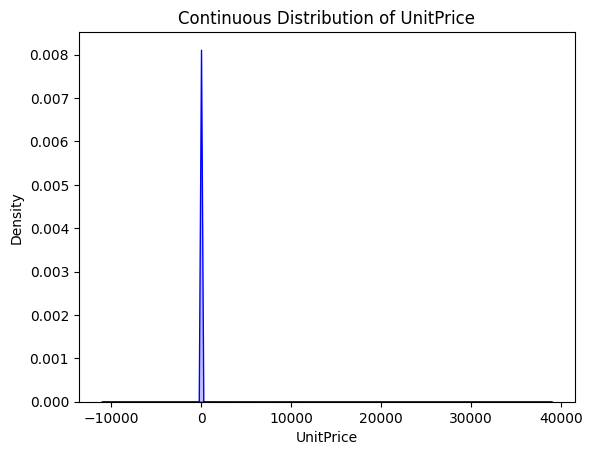

In [60]:
sns.kdeplot(df['UnitPrice'], shade=True, color='blue')
plt.title('Continuous Distribution of UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

- The UnitPrice distribution seems to be Skewed

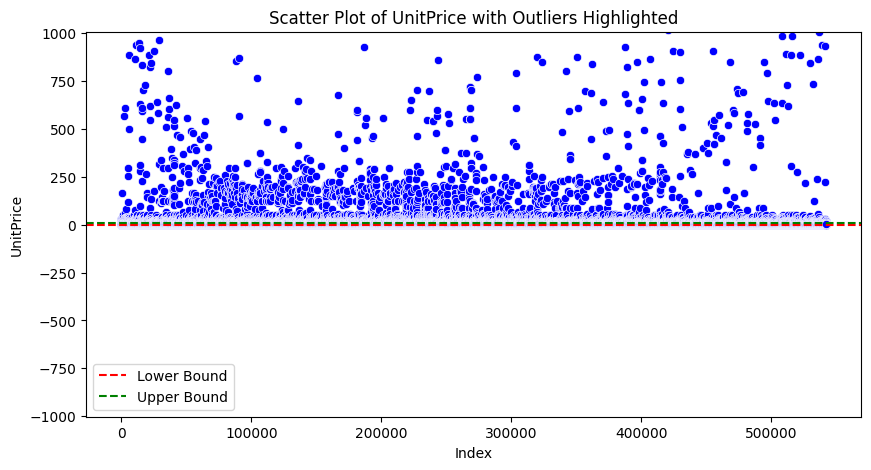

In [61]:
# Calculate IQR
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers_lower = df[df['UnitPrice'] < lower_bound]
outliers_upper = df[df['UnitPrice'] > upper_bound]


plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x=df.index, y='UnitPrice', color='blue')
plt.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axhline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.ylim(lower_bound - 1000, upper_bound + 1000)  # Adjust limits for better visibility
plt.title('Scatter Plot of UnitPrice with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('UnitPrice')
plt.legend()
plt.show()

- The data indicates a minimal presence of outliers below the lower bound for the UnitPrice variable.

### Counting and Extracting Outliers

In [62]:
# Calculate IQR
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_UnitPrice = df[(df['UnitPrice'] < lower_bound) | (df['UnitPrice'] > upper_bound)]

# Count of outliers
outlier_count_outliers_UnitPrice = outliers_UnitPrice.shape[0]
print(f"Number of outliers: {outlier_count_outliers_UnitPrice}")

Number of outliers: 39627


- There are 39627 outliers in UnitPrice, which is around almost 7 % of the data
- There are negative and positive values in the UnitPrice

In [63]:
negative_count_UnitPrice = (outliers_UnitPrice['UnitPrice'] < 0).sum()

# Count the number of positive values
positive_count_UnitPrice = (outliers_UnitPrice['UnitPrice'] > 0).sum()

print(f"Number of negative values: {negative_count_UnitPrice}")
print(f"Number of positive values: {positive_count_UnitPrice}")

Number of negative values: 2
Number of positive values: 39625


- **Negative UnitPrice Outliers**: Only two outliers are identified with negative UnitPrice values. Since unit prices cannot logically be negative and the dataset lacks context to explain these values, they can be excluded from further analysis.
- **Positive UnitPrice Outliers**: A significant number of outliers are observed in invoices with positive UnitPrice values. These outliers warrant further investigation to understand their cause and assess their impact on the dataset.

#### Exploring the patterns of data points having positive UnitPrice

In [64]:
positive_unit = outliers_UnitPrice[outliers_UnitPrice['UnitPrice'] >= 0]

In [65]:
positive_unit.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
16,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-01 08:34:00,9.95,13047.0,United Kingdom
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France
65,536374,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-01 09:09:00,10.95,15100.0,United Kingdom
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
151,536382,22839,3 TIER CAKE TIN GREEN AND CREAM,2,2010-12-01 09:45:00,14.95,16098.0,United Kingdom


In [66]:
positive_unit.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,39625.000000,39625,39625.000000,24118.000000
mean,2.492492,2011-06-17 08:34:49.347634176,31.644658,15082.171324
min,-150.000000,2010-12-01 08:34:00,8.470000,12347.000000
25%,1.000000,2011-03-03 15:02:00,9.950000,13651.750000
50%,1.000000,2011-06-20 09:41:00,11.630000,14911.000000
75%,2.000000,2011-10-10 09:56:00,15.790000,16648.500000
max,300.000000,2011-12-09 12:49:00,38970.000000,18287.000000
std,7.561155,NaN,347.892398,1740.626653


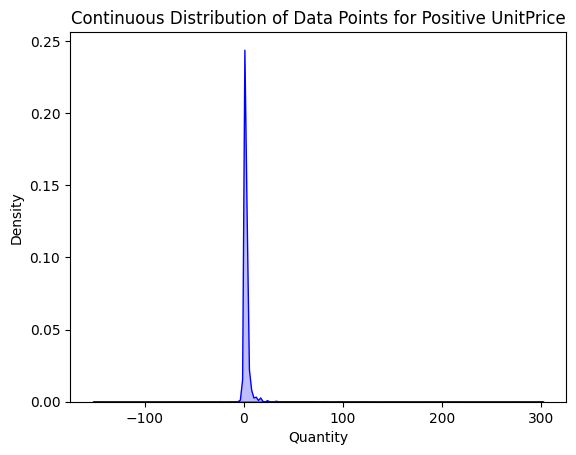

In [67]:
sns.kdeplot(positive_unit['Quantity'], shade=True, color='blue')
plt.title('Continuous Distribution of Data Points for Positive UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('Density')
plt.show()

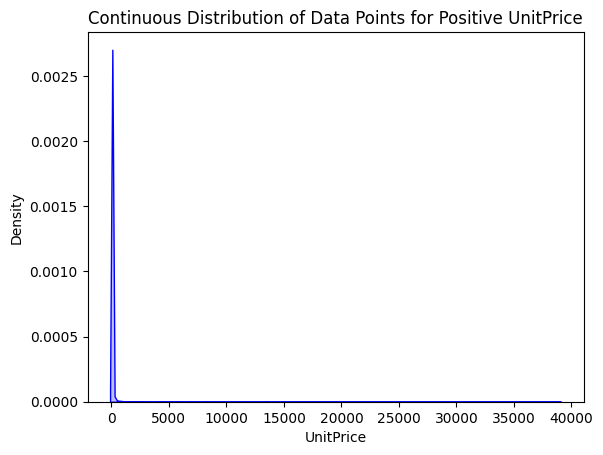

In [68]:
sns.kdeplot(positive_unit['UnitPrice'], shade=True, color='blue')
plt.title('Continuous Distribution of Data Points for Positive UnitPrice')
plt.xlabel('UnitPrice')
plt.ylabel('Density')
plt.show()

- Both the UnitPrice and Quantity datapoints are highly skewed for the invoices having positive Unit Price

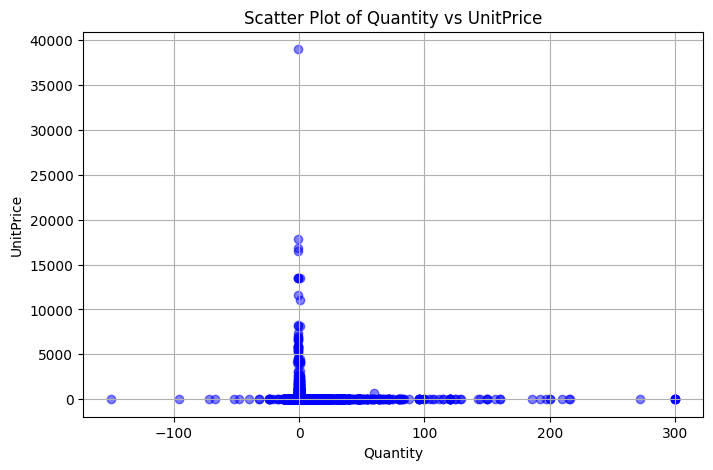

In [69]:
# Scatter plot using Matplotlib
plt.figure(figsize = (8, 5))
plt.scatter(positive_unit['Quantity'], positive_unit['UnitPrice'], color = 'blue', alpha = 0.5)
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.grid(True)
plt.show()

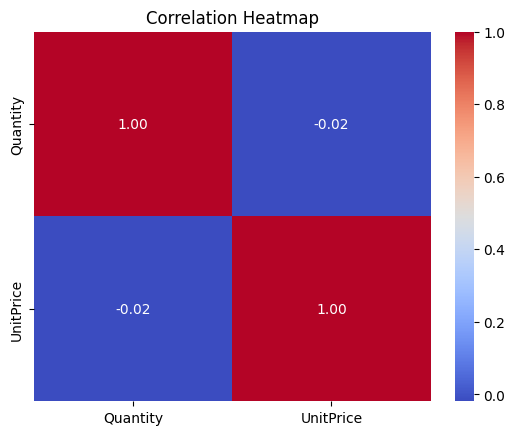

In [70]:
# Calculate correlation
correlation_matrix_unit = positive_unit[['Quantity', 'UnitPrice']].corr()

# Heatmap using Seaborn
sns.heatmap(correlation_matrix_unit, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Heatmap')
plt.show()

- There seems to be no correlation between UnitPrice and Quantity

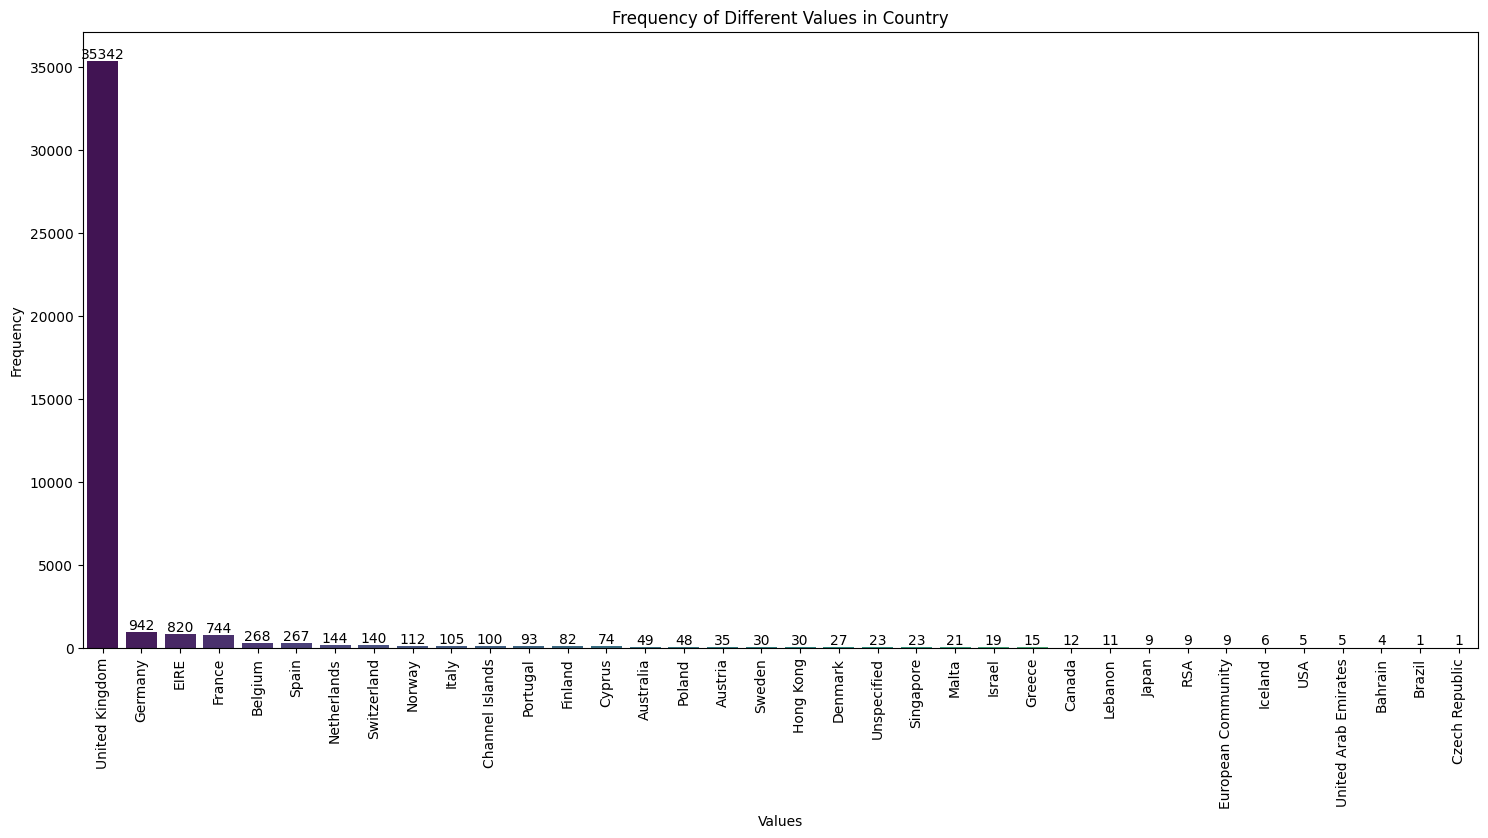

In [71]:
value_counts = positive_unit['Country'].value_counts()

# Bar plot using Seaborn
plt.figure(figsize = (18, 8))
ax = sns.barplot(x = value_counts.index, y = value_counts.values, palette = "viridis")
plt.title('Frequency of Different Values in Country')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', fontsize = 10, color = 'black', xytext = (0, 5), 
                textcoords = 'offset points')
plt.show()

- The graph indicates that the United Kingdom has the invoices with the highest positive UnitPrice

In [72]:
start_date_pos = positive_unit['InvoiceDate'].min()  # Find the earliest date
end_date_pos = positive_unit['InvoiceDate'].max()    # Find the latest date

# Calculate the range (difference between start and end date)
date_range_pos = end_date_pos - start_date_pos

print(f"Start Date: {start_date_pos}")
print(f"End Date: {end_date_pos}")
print(f"Date Range: {date_range_pos}")

Start Date: 2010-12-01 08:34:00
End Date: 2011-12-09 12:49:00
Date Range: 373 days 04:15:00


In [73]:
most_frequent_date_pos = positive_unit['InvoiceDate'].value_counts().idxmax()
frequency_pos = positive_unit['InvoiceDate'].value_counts().max()
print(f"Most Frequent Date: {most_frequent_date_pos} (Occurs {frequency_pos} times)")
filtered_rows_pos_unit = positive_unit[positive_unit['InvoiceDate'] == most_frequent_date_pos]

Most Frequent Date: 2011-10-31 14:41:00 (Occurs 126 times)


In [74]:
filtered_rows_pos_unit.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430240,573585,15056BL,EDWARDIAN PARASOL BLACK,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom
430241,573585,15056N,EDWARDIAN PARASOL NATURAL,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom
430242,573585,15058C,ICE CREAM DESIGN GARDEN PARASOL,1,2011-10-31 14:41:00,10.79,NaN,United Kingdom
430265,573585,20679,EDWARDIAN PARASOL RED,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom
430266,573585,20685,DOORMAT RED RETROSPOT,3,2011-10-31 14:41:00,15.79,NaN,United Kingdom


In [75]:
filtered_rows_pos_unit['InvoiceNo'].unique()

array([573585], dtype=object)

In [76]:
filtered_rows_pos_unit['InvoiceDate'].unique()

<DatetimeArray>
['2011-10-31 14:41:00']
Length: 1, dtype: datetime64[ns]

In [77]:
filtered_rows_pos_unit['CustomerID'].unique()

array([nan])

In [78]:
filtered_rows_pos_unit['Country'].unique()

array(['United Kingdom'], dtype=object)

### Extracting Year, Month, Day, Day of Week, and Hour

In [79]:
positive_unit['Year'] = positive_unit['InvoiceDate'].dt.year
positive_unit['Month'] = positive_unit['InvoiceDate'].dt.month
positive_unit['Day'] = positive_unit['InvoiceDate'].dt.day
positive_unit['DayOfWeek'] = positive_unit['InvoiceDate'].dt.day_name()  # Get full day name (e.g., Monday, Tuesday)
positive_unit['Hour'] = positive_unit['InvoiceDate'].dt.hour

In [80]:
positive_unit.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,Hour
16,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-01 08:34:00,9.95,13047.0,United Kingdom,2010,12,1,Wednesday,8
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,2010,12,1,Wednesday,8
65,536374,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-01 09:09:00,10.95,15100.0,United Kingdom,2010,12,1,Wednesday,9
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,12,1,Wednesday,9
151,536382,22839,3 TIER CAKE TIN GREEN AND CREAM,2,2010-12-01 09:45:00,14.95,16098.0,United Kingdom,2010,12,1,Wednesday,9


### Analyzing Day-of-Week Trends

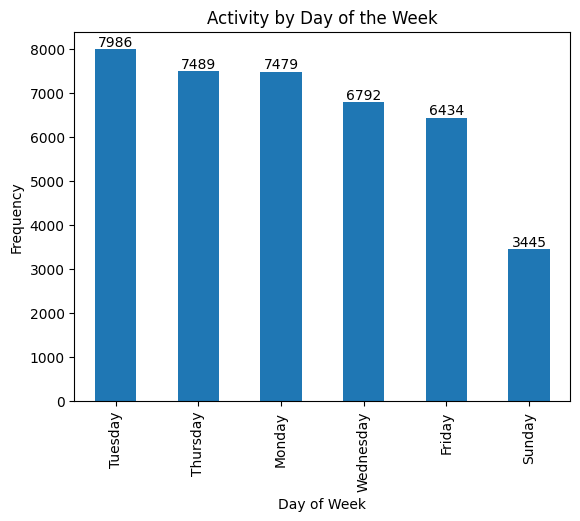

In [81]:
day_of_week_counts_pos = positive_unit['DayOfWeek'].value_counts()

# Visualization
day_of_week_counts_pos.plot(kind = 'bar', title = 'Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

for i, value in enumerate(day_of_week_counts_pos):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


- There is no transactions happening on Saturday
- Here also, the trend shows very less activity around weekend.

### Analyzing Month-of-Year Trends

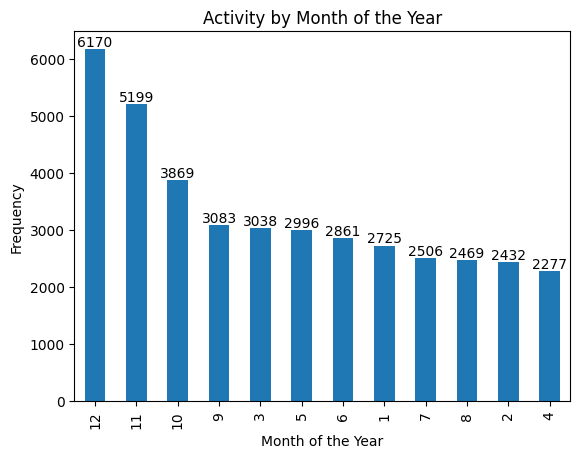

In [82]:
month_of_year_counts_pos = positive_unit['Month'].value_counts()

# Visualization
month_of_year_counts_pos.plot(kind = 'bar', title = 'Activity by Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Frequency')

for i, value in enumerate(month_of_year_counts_pos):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


- December  has the highest number of recorded transactions (6170), indicating it was the most active month for the dataset in terms of total activity.
- April has the lowest number of recorded transactions (2277), showing minimal activity during this month.
- Here the trend shows that the acivity is high during month ends comparitively.

### Analyzing Day-of-Month Trends

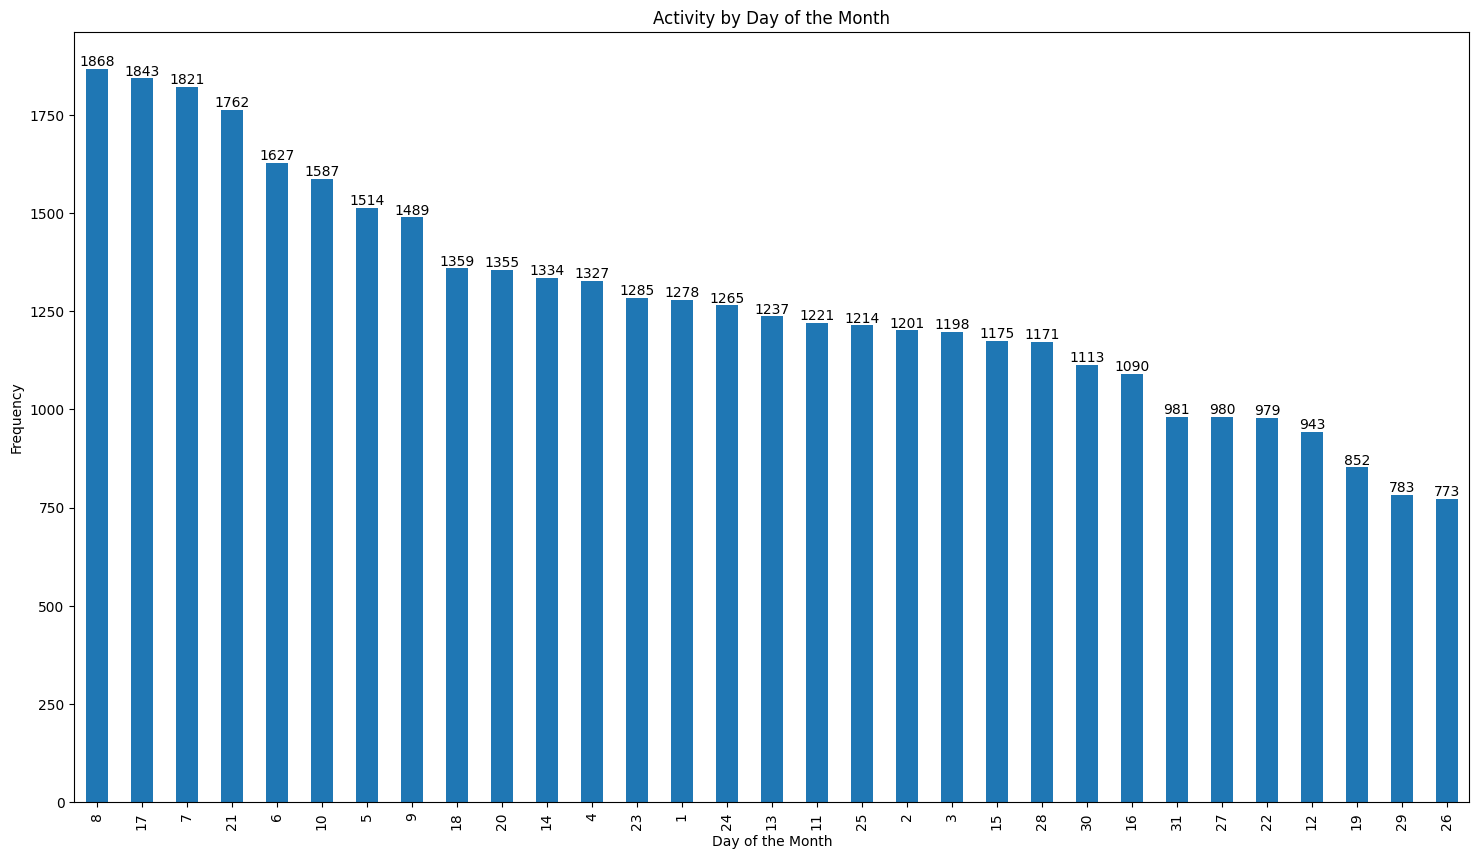

In [83]:
plt.figure(figsize=(18, 10))
Day_of_month_counts_pos = positive_unit['Day'].value_counts()

# Visualization
Day_of_month_counts_pos.plot(kind = 'bar', title = 'Activity by Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

for i, value in enumerate(Day_of_month_counts_pos):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)
    
plt.show()


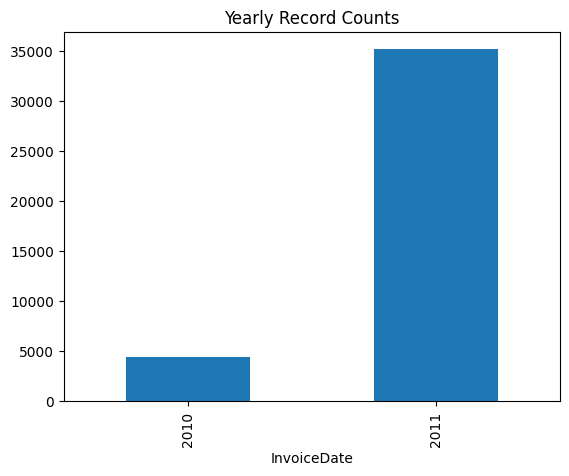

In [84]:
yearly_counts_pos = positive_unit.groupby(positive_unit['InvoiceDate'].dt.year).size()
yearly_counts_pos.plot(kind='bar', title='Yearly Record Counts')
plt.show()

- This shows the maximum transactions in the year 2011

**Conclusions from the above EDA for UnitPrice**
- **Negative UnitPrices**: It is advisable to exclude data points with negative UnitPrices since unit prices cannot logically be negative. Additionally, this dataset lacks sufficient context to explain the meaning of negative values.
- **Positive UnitPrices**: For data points with positive UnitPrices identified as outliers, further analysis is required. I will examine the distribution of normal positive UnitPrices and compare them with these outliers to keep or replace these values
- Most of the activity happens in the weekdays rather than weekend in terms of days of the week
- Most of the activity happens in the last few months in terms of months of the year
- A similar pattern in data trends was observed for the outlier data points in the Quantity variable

### Investigating other variables when the Quantity is Negative

- Since we have decided to drop the data points with negative quantity, it is essential to analyze their impact on the dataset by examining associated variables and identifying patterns within this subset of data.
- Given that there are null and duplicate values in the Customer ID column, which functions as a primary key for this dataset, I will base this evaluation on the total number of data points rather than relying solely on the unique Customer ID values

In [85]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [86]:
df.shape

(541909, 8)

In [87]:
negative_quantity = df[df['Quantity'] < 0]

In [88]:
negative_quantity.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [89]:
negative_quantity.shape

(10624, 8)

In [90]:
negative_quantity['Country'].unique()

array(['United Kingdom', 'Germany', 'EIRE', 'Italy', 'France',
       'Australia', 'Sweden', 'Portugal', 'Austria', 'Israel', 'Belgium',
       'Bahrain', 'Spain', 'Japan', 'Channel Islands', 'Netherlands',
       'Switzerland', 'Cyprus', 'Norway', 'Saudi Arabia', 'Hong Kong',
       'Poland', 'Finland', 'Czech Republic', 'Singapore',
       'European Community', 'Malta', 'Greece', 'Denmark', 'USA'],
      dtype=object)

In [91]:
negative_quantity['CustomerID'].isna().sum()

np.int64(1719)

There are 1719 null Customer IDs that will be discarded if we ignore the data points with negative quantities

In [92]:
len(negative_quantity['CustomerID'].unique())

1590

There are 1590 Customer IDs that will be discarded if we ignore the data points with negative quantities

In [93]:
len(negative_quantity['InvoiceNo'].unique())

5172

There are 5172 Invoices that will be discarded if we ignore the data points with negative quantities

In [94]:
len(negative_quantity['UnitPrice'].unique())

574

In [95]:
negative_quantity_unit = negative_quantity[negative_quantity['UnitPrice'] < 0]

In [96]:
negative_quantity_unit.shape

(0, 8)

**To summarize the impact of removing data points with negative Quantity values:**
- A total of 10,624 data points will be excluded.
- This includes 1,719 records with null Customer ID values.
- Additionally, 1,590 unique Customer ID values will be removed.
- 5,172 distinct invoices will be discarded.
- Among the discarded data, there are 574 unique positive UnitPrice values.

### Investigating other variables when the UnitPrice is Negative

In [97]:
negative_UnitPrice = df[df['UnitPrice'] < 0]

In [98]:
negative_UnitPrice.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


- There are only 2 data points with negative UnitPrice and hence discarding these 2 data points might not affect the dataset much as these are anyways outliers as well

### Lets have a check on what are the top keywords(Description) associated with these negative values

Since there are only 2 data points in the UnitPrice with negative values, I am merging negative UnitPrice and negative quantity dataset

In [99]:
negative_df = pd.concat([negative_quantity, negative_UnitPrice], ignore_index=True)

In [100]:
negative_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
1,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
2,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
3,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
4,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [101]:
negative_df.shape

(10626, 8)

In [102]:
negative_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,10626.000000,10626,10626.000000,8905.000000
mean,-45.598438,2011-06-24 19:45:23.015245568,40.217975,14991.667266
min,-80995.000000,2010-12-01 09:41:00,-11062.060000,12346.000000
25%,-10.000000,2011-03-24 11:24:00,1.060000,13510.000000
50%,-2.000000,2011-07-04 15:59:00,2.100000,14895.000000
75%,-1.000000,2011-10-06 19:51:45,4.950000,16393.000000
max,1.000000,2011-12-09 11:58:00,38970.000000,18282.000000
std,1092.111602,NaN,641.765091,1706.772357


In [103]:
 # nltk.download()

In [104]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [105]:
def clean_text(text, stop_words):
    # Ensure the input is a string before applying .lower()
    text = str(text).lower()

    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Split into words and filter stopwords
    words = [word for word in text.split() if word.isalnum() and word not in stop_words] 

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Returning list of cleaned words
    return words 
    


In [106]:
# Apply the clean_text function to the Description column
negative_df['Cleaned_Description'] = negative_df['Description'].apply(lambda x: clean_text(x, stop_words))

# Convert list of words back into a single string for each row
negative_df['Cleaned_Description_Joined'] = negative_df['Cleaned_Description'].apply(lambda x: ' '.join(x))

# Filtering nan values
negative_df = negative_df[negative_df['Cleaned_Description_Joined'] != 'nan']

In [107]:
negative_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cleaned_Description,Cleaned_Description_Joined
0,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,[discount],discount
1,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,"[set, coloured, flying, duck]",set coloured flying duck
2,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,"[plaster, tin, circus, parade]",plaster tin circus parade
3,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,"[pack, pink, paisley, tissue]",pack pink paisley tissue
4,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,"[pack, blue, paisley, tissue]",pack blue paisley tissue


In [108]:
negative_df.shape

(9764, 10)

### Get unigrams (single words)

In [109]:
# Tokenize the text into words for unigram analysis
all_words = [word for sublist in negative_df['Cleaned_Description_Joined'] for word in sublist.split()]
freq_unigrams = nltk.FreqDist(all_words)

In [110]:
freq_unigrams

FreqDist({'set': 1064, 'red': 797, 'retrospot': 707, 'bag': 695, 'box': 616, 'cake': 568, 'heart': 525, 'design': 499, 'glass': 483, 'vintage': 473, ...})

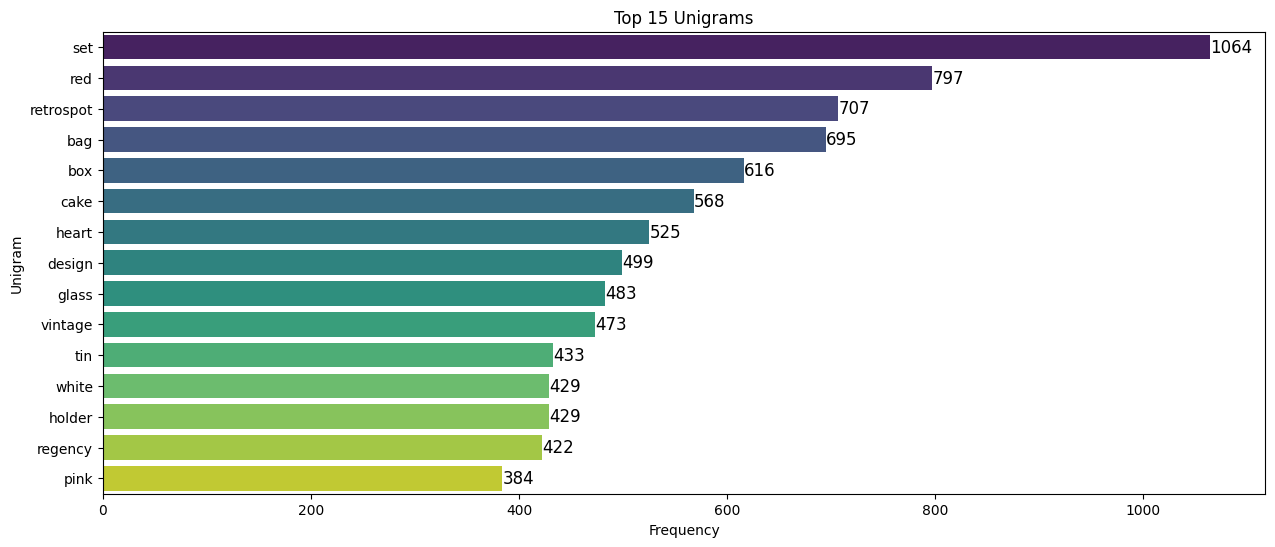

In [111]:
top_unigrams = freq_unigrams.most_common(15)
top_unigrams_df = pd.DataFrame(top_unigrams, columns=['Word', 'Frequency'])

# Plot the top unigrams
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='Frequency', y='Word', data=top_unigrams_df, palette='viridis')
plt.title('Top 15 Unigrams')
plt.xlabel('Frequency')
plt.ylabel('Unigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_unigrams_df['Frequency']):
    ax.text(v + 0.2, i, str(v), color='black', va='center', fontsize=12)

plt.show()

**This Unigram distribution highlights that**
- Words like "red," "retrospot," "bag," "box," and "cake" suggest the dataset might involve descriptions of retail or e-commerce products. These terms likely highlight common product categories or attributes.
- Words like "design," "vintage," "glass," "white," and "pink" suggest a focus on product aesthetics or material characteristics. This might indicate that visual and stylistic aspects are prominent in this dataset.

### Get bigrams (pairs of words)

In [113]:
# Generate bigrams
all_bigrams = list(ngrams(all_words, 2))
freq_bigrams = nltk.FreqDist(all_bigrams)

In [114]:
freq_bigrams

FreqDist({('red', 'retrospot'): 428, ('tlight', 'holder'): 300, ('jumbo', 'bag'): 220, ('lunch', 'bag'): 212, ('cakestand', 'tier'): 210, ('regency', 'cakestand'): 181, ('cake', 'stand'): 172, ('cake', 'tin'): 166, ('regency', 'teacup'): 131, ('teacup', 'saucer'): 131, ...})

In [115]:
top_bigrams = freq_bigrams.most_common(15)
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
top_bigrams_df['Bigram'] = top_bigrams_df['Bigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string

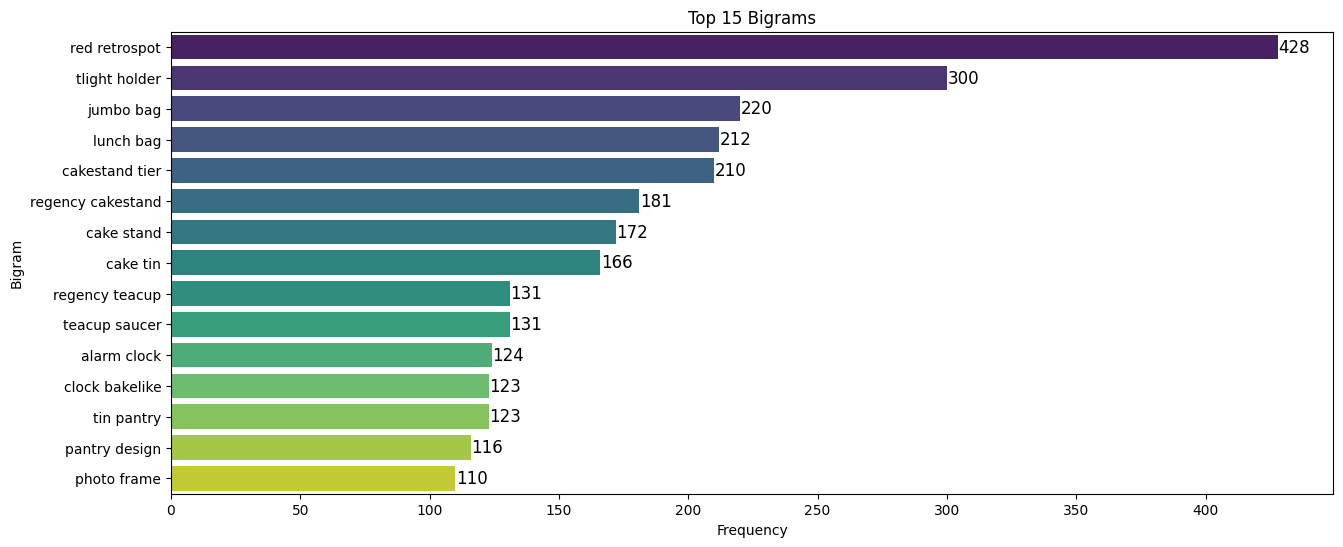

In [116]:
# Plot the top bigrams
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, palette='viridis')
plt.title('Top 15 Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_bigrams_df['Frequency']):
    ax.text(v + 0.2, i, str(v), color='black', va='center', fontsize=12)

plt.show()

**This Bigram distribution highlights that**
- Bigrams like "tlight holder", "cake stand", and "photo frame", "alarm clock" suggest common product categories, specifically related to household or decorative items.
- Bigrams like "lunch bag", "regency teacup", "tin pantry" suggest common words related to kitchen

### Get trigrams (triples of words)

In [117]:
# Generate trigrams
all_trigrams = list(ngrams(all_words, 3))
freq_trigrams = nltk.FreqDist(all_trigrams)

In [118]:
freq_trigrams

FreqDist({('regency', 'cakestand', 'tier'): 181, ('regency', 'teacup', 'saucer'): 131, ('alarm', 'clock', 'bakelike'): 123, ('jam', 'making', 'set'): 100, ('bag', 'red', 'retrospot'): 92, ('making', 'set', 'jar'): 87, ('tin', 'pantry', 'design'): 86, ('ceramic', 'trinket', 'box'): 84, ('hot', 'water', 'bottle'): 80, ('heart', 'tlight', 'holder'): 75, ...})

In [119]:
top_trigrams = freq_trigrams.most_common(15)
top_trigrams_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Frequency'])
top_trigrams_df['Trigram'] = top_trigrams_df['Trigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string

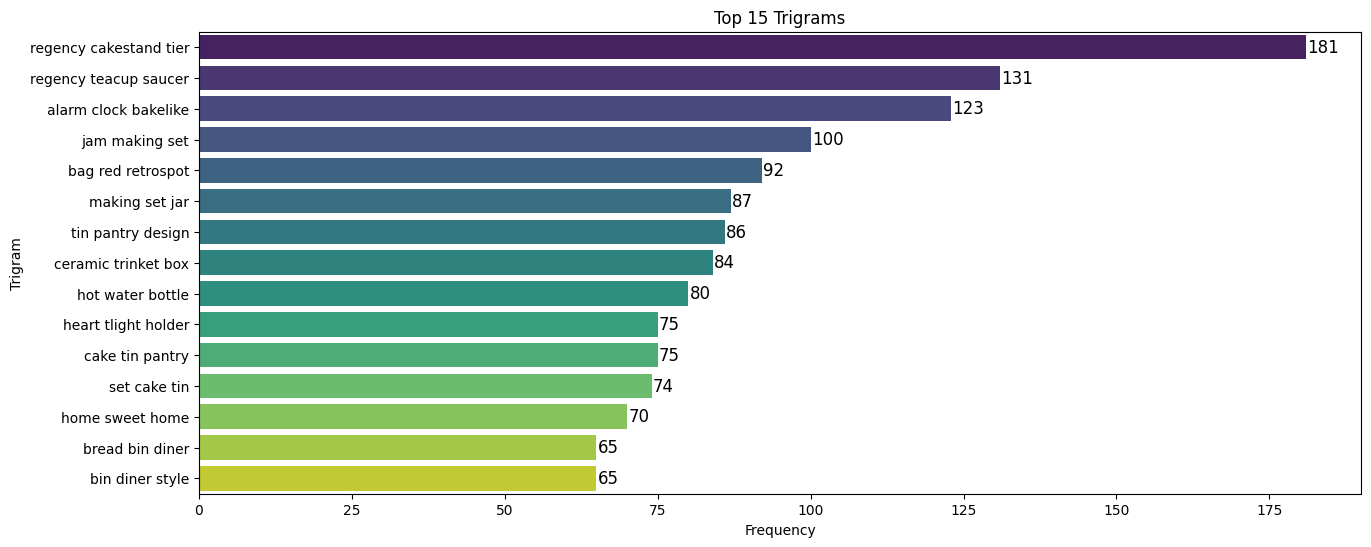

In [120]:
# Plot the top trigrams
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='Frequency', y='Trigram', data=top_trigrams_df, palette='viridis')
plt.title('Top 15 Trigrams')
plt.xlabel('Frequency')
plt.ylabel('Trigram')

# Display the frequency on top of the bars
for i, v in enumerate(top_trigrams_df['Frequency']):
    ax.text(v + 0.2, i, str(v), color='black', va='center', fontsize=12)

plt.show()

- Examples like "regency cakestand tier," "regency teacup saucer," and "alarm clock bakelike" highlight products associated with dining sets, tea-time accessories, and clocks, possibly vintage or styled for decorative purposes.
- Other trigrams like "jam making set" and "hot water bottle" point towards kitchen tools or household essentials.

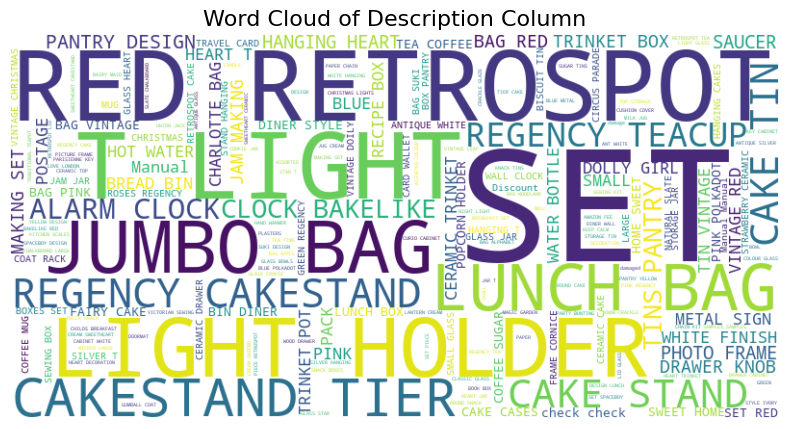

In [121]:
# Combine all sentences into a single string
text = " ".join(negative_df['Description'].dropna().astype(str))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Description Column', fontsize=16)
plt.show()

- Words like "set," "bag," "cake stand," "holder," "red," "retrospot," and "lunch" suggest items used in home organization, kitchenware, and decoration.
- The presence of words like "ceramic," "trinket," "photo frame," "regency," and "design" indicates decorative products, likely vintage or aesthetically appealing items. 

**To Conclude the words are closely linked to:**
- Home and kitchen items (e.g., cake stands, lunch bags, teacup sets)
- Decorative items (e.g., light holders, ceramic trinkets, photo frames).
- Vintage or retro-themed products (e.g., regency-style items, retrospot patterns).
- Gift items (e.g., personalized or aesthetically pleasing objects).

### Data Extraction

Since the dataset contains negative values for Quantity and UnitPrice which are not relevant for clustering analysis, I am creating a subset of the data that includes only records with positive Quantity and UnitPrice. The clustering algorithm will then be applied exclusively to this filtered subset.

In [129]:
subset_df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [130]:
subset_df.shape

(530104, 8)

In [131]:
subset_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,530104.000000,530104,530104.000000,397884.000000
mean,10.542037,2011-07-04 20:16:05.225087744,3.907625,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 12:22:00,1.250000,13969.000000
50%,3.000000,2011-07-20 12:58:00,2.080000,15159.000000
75%,10.000000,2011-10-19 12:39:00,4.130000,16795.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,155.524124,NaN,35.915681,1713.141560


In [132]:
subset_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [133]:
# Save the filtered DataFrame to a CSV file
file_path = r"C:\Users\samru\Study\Study_Abroad\Projects_To_Showcase\Customer_Segmentation\data\subset_df.csv"  # Replace with your desired file path
subset_df.to_csv(file_path, index = False)

print(f"Filtered DataFrame saved to {file_path}")


Filtered DataFrame saved to C:\Users\samru\Study\Study_Abroad\Projects_To_Showcase\Customer_Segmentation\data\subset_df.csv


### Some observations from this exploratory data analysis

- Customer ID is usually the primary key for these kind of datasets, but approximately **135,080** entries **(25%)** of this field are **missing**.
- Quantity and UnitPrice are variables that should ideally hold only positive values; however, the **dataset contains negative values**, accounting for **2% of Quantity** and **0.0004% of UnitPrice**.
- A significant number of outliers are present, particularly in **Quantity (11%)** and **UnitPrice (7%)**, indicating potential anomalies or extreme values.
- The majority of the dataset's audience is concentrated in the **United Kingdom**.
- Both **Quantity and UnitPrice** exhibit a skewed distribution, deviating from normality.
- **Purchasing trends** reveal that the majority of activity occurs on **weekdays** rather than weekends and spikes towards the **end of the year**.
- The dataset covers a time span of **2010 to 2011**, with the bulk of invoices generated in **2011**.
- The negative values in **Quantity or UnitPrice** are most frequently associated with products such as **home and kitchen items, decorative pieces, vintage or retro-themed products, and gift items**.